Imports and Data Preprocessing

In [ ]:
!pip install linearmodels
!pip install semopy

In [3]:
# Block 1: Imports, Configuration, Main Data Loading & Prep, Instrument Loading & Prep, Merge, Final Index Setting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from linearmodels import PanelOLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from linearmodels.system import SUR
from linearmodels.iv import IV2SLS
from semopy import Model
import warnings # To handle potential warnings

# --- Configuration ---
DATA_FILE = "finalCleanedByDevelopmentStatus.csv"
HISTORICAL_TELEPHONE_FILE = "54bd87ba-fe26-4ae0-9380-0cae854d4233_Data.csv" # <<< YOUR INSTRUMENT CSV FILENAME
INSTRUMENT_YEAR_LABEL = '2005' # <<< CHOOSE YOUR HISTORICAL YEAR (e.g., '2005', '2002')
SKIP_ROWS_INSTRUMENT = 3 # <<< ADJUST THIS BASED ON YOUR CSV FILE INSPECTION (Likely 3 or 4)
HEADER_ROW_INSTRUMENT = 0 # <<< ADJUST THIS (Likely 0 if you removed metadata lines, or same as skiprows)

# Construct column names based on the chosen year
# Use the simplified header format found in the cleaned CSV
instrument_year_col = INSTRUMENT_YEAR_LABEL # e.g., '2005'
instrument_col_name = f'historicalphonesper100_{INSTRUMENT_YEAR_LABEL}' # e.g., 'historicalphonesper100_2005'

# Define columns to convert to numeric - INSTRUMENT_COL will be added IF merge is successful
NUMERIC_COLS = [
    'year', 'fixedbroadbandper100', 'internetuserspercent',
    'povertynationallinepercent', 'adultliteracyratetotal',
    'gdppercapitacurrentusd', 'urbanpopulationpercenttotal',
    'lifeexpectancyatbirthtotal', 'gdpgrowthannualpercent'
]
# Define a placeholder for the instrument column name - will be updated after merge
INSTRUMENT_COL = instrument_col_name # Set based on chosen year

# --- Load Main Data ---
print(f"--- Loading Main Data ---")
try:
    df_main_raw = pd.read_csv(DATA_FILE)
    print(f"Successfully loaded main data from {DATA_FILE}")
except FileNotFoundError:
    print(f"Error: Main data file '{DATA_FILE}' not found. Please place it in the correct directory.")
    df_main_raw = pd.DataFrame()

df_prepped = pd.DataFrame() # Initialize prepped dataframe

if not df_main_raw.empty:
    # --- Main Data Preprocessing ---
    print("\n--- Preprocessing Main Data ---")
    df_prepped = df_main_raw.copy() # Work on a copy

    # Convert relevant columns to numeric
    for col in NUMERIC_COLS:
        if col in df_prepped.columns:
            df_prepped[col] = pd.to_numeric(df_prepped[col], errors='coerce')

    # Convert country to categorical
    if 'country' in df_prepped.columns:
        df_prepped['country'] = df_prepped['country'].astype('category')
    else:
        print("Warning: 'country' column not found.")

    # Create log-transformed GDP per capita
    if 'gdppercapitacurrentusd' in df_prepped.columns:
        df_prepped.loc[df_prepped['gdppercapitacurrentusd'] <= 0, 'gdppercapitacurrentusd'] = np.nan
        df_prepped['log_gdp_per_capita'] = np.log(df_prepped['gdppercapitacurrentusd'])
        print("Created 'log_gdp_per_capita'.")
    else:
        print("Warning: 'gdppercapitacurrentusd' column not found, cannot create log GDP.")

    print("Main data preprocessing complete (Index not set yet).")
else:
    print("Main DataFrame is empty, skipping preprocessing.")


# --- Instrument Data Loading and Preparation ---
df_instrument_raw = pd.DataFrame() # Initialize
df_instrument = pd.DataFrame()     # Initialize prepared instrument dataframe
print(f"\n--- Loading and Preparing Instrument Data ({instrument_col_name}) ---")
try:
    # Try reading with different encodings and specified header
    try:
        # Use header=HEADER_ROW_INSTRUMENT. If metadata was removed, this is likely 0.
        # Remove skiprows if header=0 is used, otherwise set skiprows correctly.
        if HEADER_ROW_INSTRUMENT == 0:
             df_instrument_raw = pd.read_csv(HISTORICAL_TELEPHONE_FILE, header=HEADER_ROW_INSTRUMENT, encoding='utf-8')
        else: # Use both if header is not the first line after metadata
             df_instrument_raw = pd.read_csv(HISTORICAL_TELEPHONE_FILE, skiprows=SKIP_ROWS_INSTRUMENT, header=HEADER_ROW_INSTRUMENT, encoding='utf-8')
        print(f"Attempted load with utf-8 encoding (header={HEADER_ROW_INSTRUMENT}).")
    except UnicodeDecodeError:
        print("utf-8 encoding failed, trying latin1...")
        try:
             if HEADER_ROW_INSTRUMENT == 0:
                  df_instrument_raw = pd.read_csv(HISTORICAL_TELEPHONE_FILE, header=HEADER_ROW_INSTRUMENT, encoding='latin1')
             else:
                  df_instrument_raw = pd.read_csv(HISTORICAL_TELEPHONE_FILE, skiprows=SKIP_ROWS_INSTRUMENT, header=HEADER_ROW_INSTRUMENT, encoding='latin1')
             print(f"Successfully loaded with latin1 encoding (header={HEADER_ROW_INSTRUMENT}).")
        except Exception as e_latin1:
             print(f"Error loading with latin1: {e_latin1}")
             # df_instrument_raw remains empty
except FileNotFoundError:
    print(f"Error: Historical telephone data file '{HISTORICAL_TELEPHONE_FILE}' not found.")
except Exception as e_outer:
    print(f"General error loading historical telephone data: {e_outer}")

if not df_instrument_raw.empty:
    print("\nSample of loaded instrument headers:", df_instrument_raw.columns.tolist()[:10])
    # Check if the required columns exist ('Country Name' and the year)
    if instrument_year_col not in df_instrument_raw.columns:
        print(f"\nError: Target instrument year column '{instrument_year_col}' not found.")
    elif 'Country Name' not in df_instrument_raw.columns:
         print("\nError: 'Country Name' column not found in instrument data.")
    else:
        # --- Select relevant columns: 'Country Name' and the chosen year column ---
        required_raw_cols = ['Country Name', instrument_year_col]
        # REMOVED check/inclusion of 'Country Code'
        df_instrument = df_instrument_raw[required_raw_cols].copy()

        # --- Rename columns for merging and clarity ---
        # REMOVED 'Country Code' from rename_dict
        rename_dict = {
            'Country Name': 'country_name',
            instrument_year_col: instrument_col_name
        }
        df_instrument.rename(columns=rename_dict, inplace=True)

        # --- Convert the instrument column to numeric ---
        df_instrument[instrument_col_name] = pd.to_numeric(df_instrument[instrument_col_name], errors='coerce')

        # --- Clean Data ---
        initial_rows = len(df_instrument)
        df_instrument.dropna(subset=[instrument_col_name], inplace=True)
        print(f"\nDropped {initial_rows - len(df_instrument)} rows with missing instrument data for {instrument_year_label}.")

        # REMOVED filtering by Country Code
        print("Skipping aggregate filtering (requires Country Code, which was removed).")
        print(f"\nPrepared instrument data using year {instrument_year_label}.")
        # print(df_instrument.head()) # Uncomment to check
else:
    print("\nSkipping instrument preparation as raw telephone data failed to load or was empty.")


# --- Merge Instrument into Main DataFrame ---
print("\n--- Merging Instrument Data ---")
merge_successful = False
if not df_prepped.empty and not df_instrument.empty:
    # Merge ONLY on Country Name as per user confirmation that Code was deleted
    if 'country' in df_prepped.columns and 'country_name' in df_instrument.columns:
        print("Attempting merge on Country Name...")
        original_len = len(df_prepped)
        df_merged_temp = pd.merge(df_prepped, df_instrument[['country_name', instrument_col_name]],
                                  left_on='country', right_on='country_name',
                                  how='left')

        if len(df_merged_temp) == original_len and instrument_col_name in df_merged_temp.columns:
             df_merged_temp.drop('country_name', axis=1, inplace=True, errors='ignore')
             df_prepped = df_merged_temp # Update main dataframe
             merge_successful = True
             print(f"Successfully merged instrument '{instrument_col_name}' based on Country Name.")
        else:
             print("Warning: Merge on Country Name might have failed or produced unexpected results.")
    else:
        print("Error: Cannot merge. Check required columns ('country' in main data, 'country_name' in instrument data).")

    if merge_successful:
        INSTRUMENT_COL = instrument_col_name
        print(f"INSTRUMENT_COL variable updated globally to: {INSTRUMENT_COL}")
        if INSTRUMENT_COL not in NUMERIC_COLS:
            NUMERIC_COLS.append(INSTRUMENT_COL)
            df_prepped[INSTRUMENT_COL] = pd.to_numeric(df_prepped[INSTRUMENT_COL], errors='coerce')

        print(f"\nNumber of observations with non-missing instrument data: {df_prepped[INSTRUMENT_COL].notna().sum()} out of {len(df_prepped)} total.")
        missing_percentage = df_prepped[INSTRUMENT_COL].isna().mean() * 100
        print(f"Percentage of observations MISSING the instrument: {missing_percentage:.2f}%")
    else:
         print("Merge failed. Instrument variable not added to 'df_prepped'.")
else:
     print("Skipping merge step as 'df_prepped' or 'df_instrument' is missing/empty.")


# --- Final Step: Set Panel Index ---
# Always attempt to set index if data exists and columns are present
print("\n--- Setting Panel Index ---")
if not df_prepped.empty and 'country' in df_prepped.columns and 'year' in df_prepped.columns:
    try:
        # If index is already set correctly, this won't hurt.
        # If columns exist but aren't index, set it.
        if not isinstance(df_prepped.index, pd.MultiIndex) or df_prepped.index.names != ['country', 'year']:
             # Reset index first if it exists but is wrong, or if columns aren't index yet
             if isinstance(df_prepped.index, pd.MultiIndex):
                 df_prepped.reset_index(inplace=True)
             elif df_prepped.index.name is not None: # Handles single index case
                 df_prepped.reset_index(inplace=True)

             # Now set the correct MultiIndex
             df_prepped.set_index(['country', 'year'], inplace=True)
             print("Set 'country' and 'year' as index for panel analysis.")
        else:
            print("Index ('country', 'year') was already correctly set.")

    except KeyError:
         print("Error: Could not set panel index. 'country' or 'year' column might be missing after potential merge issues.")
    except Exception as e:
        print(f"Could not set panel index. Error: {e}. Panel models might fail.")
elif not df_prepped.empty:
     print("Warning: Could not set panel index ('country' or 'year' column missing). Panel models might fail.")
else:
    print("Skipping index setting as main dataframe is empty.")

# --- End of Block 1 ---
print("\n--- Finished Setup and Data Preparation ---")
# df_prepped DataFrame is now ready for subsequent analysis blocks

--- Loading Main Data ---
Successfully loaded main data from finalCleanedByDevelopmentStatus.csv

--- Preprocessing Main Data ---
Created 'log_gdp_per_capita'.
Main data preprocessing complete (Index not set yet).

--- Loading and Preparing Instrument Data (historicalphonesper100_2005) ---
Error: Historical telephone data file '54bd87ba-fe26-4ae0-9380-0cae854d4233_Data.csv' not found.

Skipping instrument preparation as raw telephone data failed to load or was empty.

--- Merging Instrument Data ---
Skipping merge step as 'df_prepped' or 'df_instrument' is missing/empty.

--- Setting Panel Index ---
Set 'country' and 'year' as index for panel analysis.

--- Finished Setup and Data Preparation ---


Descriptive Statistics and Initial Visualizations

--- Descriptive Statistics ---
       fixedbroadbandper100  internetuserspercent  povertynationallinepercent  \
count           2387.000000           2387.000000                 2387.000000   
mean              14.978357             58.171177                   24.387830   
std               14.804547             28.808675                   13.445063   
min                0.000000              0.900000                    0.000000   
25%                1.321290             33.800000                   14.800000   
50%                9.956780             64.100000                   22.500000   
75%               27.686050             83.350000                   25.600000   
max               75.749700            100.000000                   82.300000   

       adultliteracyratetotal  
count             2387.000000  
mean                87.144818  
std                 16.421415  
min                 22.000000  
25%                 85.430000  
50%                 94.000000  
75%            

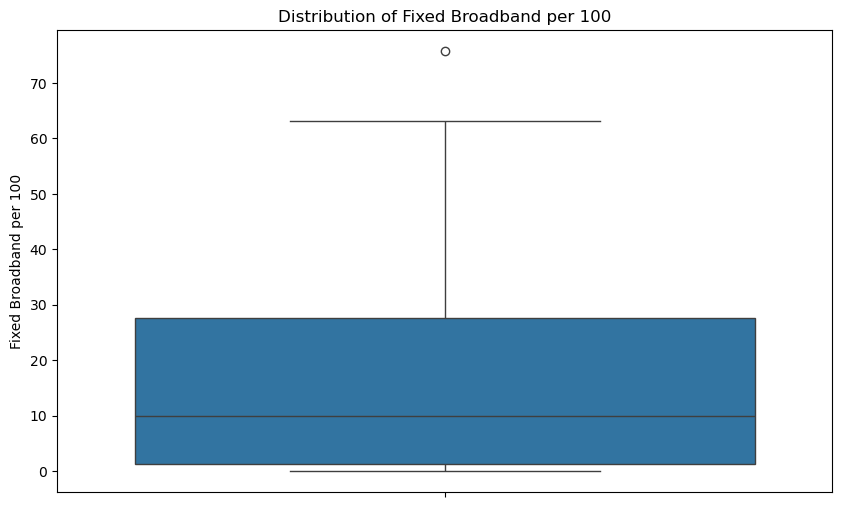

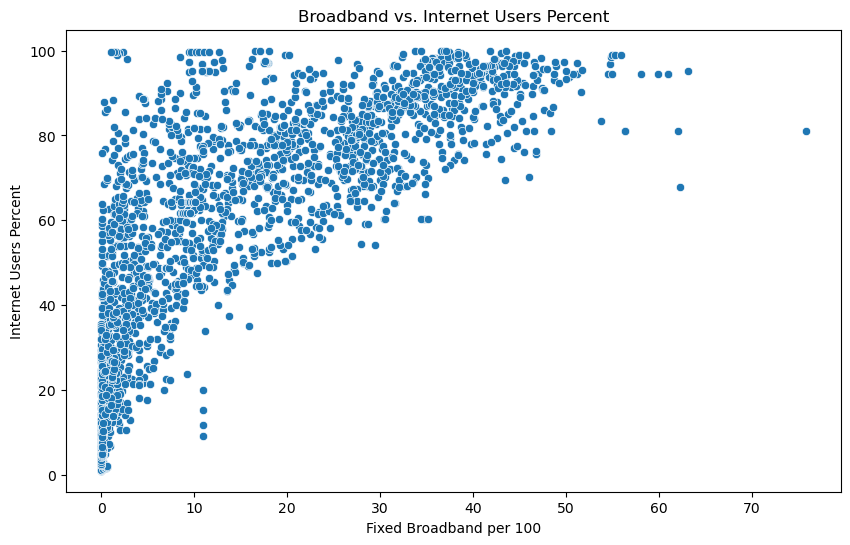

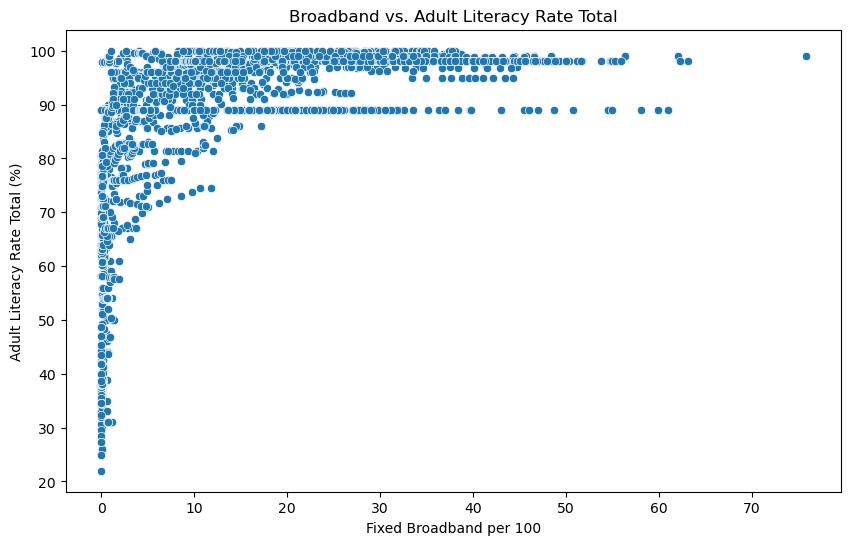

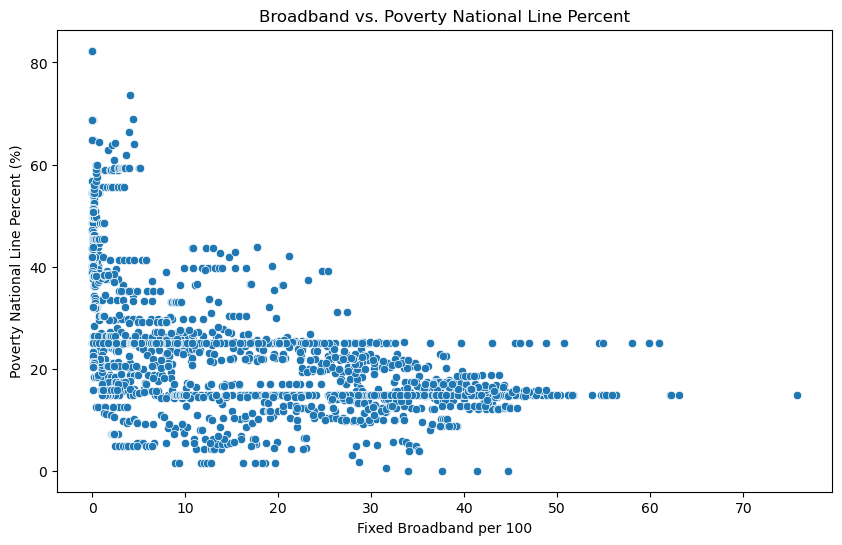

\n--- Correlation Matrix ---
                             fixedbroadbandper100  internetuserspercent  \
fixedbroadbandper100                     1.000000              0.776125   
internetuserspercent                     0.776125              1.000000   
povertynationallinepercent              -0.527481             -0.617737   
adultliteracyratetotal                   0.560339              0.715521   
gdppercapitacurrentusd                   0.689242              0.578291   
urbanpopulationpercenttotal              0.522296              0.641327   
lifeexpectancyatbirthtotal               0.758684              0.799982   

                             povertynationallinepercent  \
fixedbroadbandper100                          -0.527481   
internetuserspercent                          -0.617737   
povertynationallinepercent                     1.000000   
adultliteracyratetotal                        -0.646878   
gdppercapitacurrentusd                        -0.388826   
urbanpopulationp

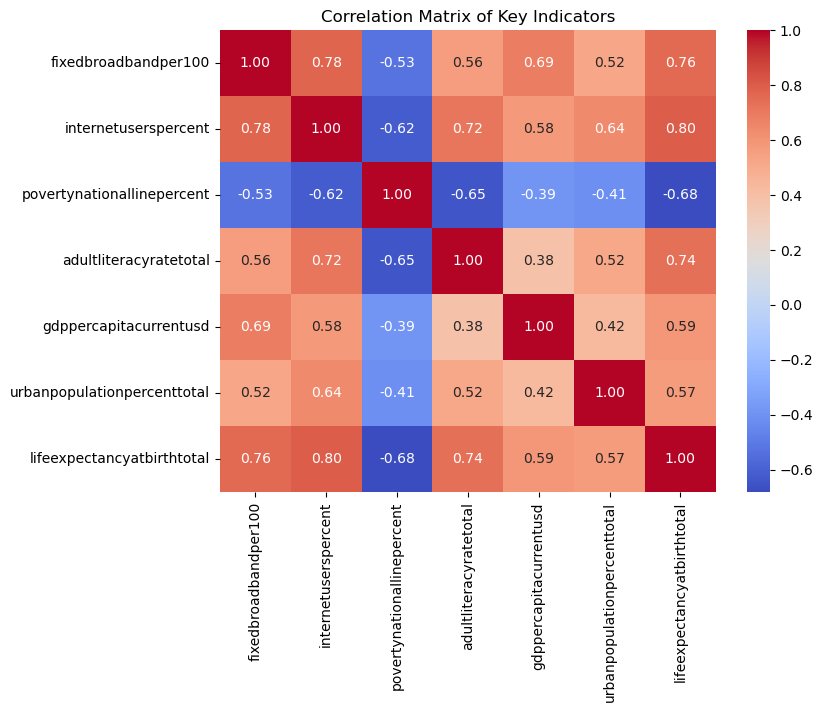

In [6]:
if not df_prepped.empty:
    print("--- Descriptive Statistics ---")
    key_vars_desc = ['fixedbroadbandper100', 'internetuserspercent', 'povertynationallinepercent', 'adultliteracyratetotal']
    # Check if columns exist before describing
    existing_key_vars = [col for col in key_vars_desc if col in df_prepped.columns]
    if existing_key_vars:
        print(df_prepped[existing_key_vars].describe())
    else:
        print("No key variables found for description.")

    # Boxplot: Fixed Broadband per 100
    if 'fixedbroadbandper100' in df_prepped.columns:
        plt.figure(figsize=(10,6))
        sns.boxplot(y='fixedbroadbandper100', data=df_prepped.reset_index())
        plt.title('Distribution of Fixed Broadband per 100')
        plt.ylabel('Fixed Broadband per 100')
        plt.savefig("Boxplot_FixedBroadband.png")
        plt.show()

    # Scatter Plot: Broadband vs. Internet Users
    if 'fixedbroadbandper100' in df_prepped.columns and 'internetuserspercent' in df_prepped.columns:
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='fixedbroadbandper100', y='internetuserspercent', data=df_prepped.reset_index())
        plt.title('Broadband vs. Internet Users Percent')
        plt.xlabel('Fixed Broadband per 100')
        plt.ylabel('Internet Users Percent')
        plt.savefig("Scatter_Broadband_Internet.png")
        plt.show()

    # --- ADDED: Scatter Plot: Broadband vs. Adult Literacy ---
    if 'fixedbroadbandper100' in df_prepped.columns and 'adultliteracyratetotal' in df_prepped.columns:
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='fixedbroadbandper100', y='adultliteracyratetotal', data=df_prepped.reset_index())
        plt.title('Broadband vs. Adult Literacy Rate Total')
        plt.xlabel('Fixed Broadband per 100')
        plt.ylabel('Adult Literacy Rate Total (%)')
        plt.savefig("Scatter_Broadband_Literacy.png")
        plt.show()
    else:
        print("Skipping Broadband vs Literacy plot: Required columns missing.")

    # --- ADDED: Scatter Plot: Broadband vs. Poverty ---
    if 'fixedbroadbandper100' in df_prepped.columns and 'povertynationallinepercent' in df_prepped.columns:
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='fixedbroadbandper100', y='povertynationallinepercent', data=df_prepped.reset_index())
        plt.title('Broadband vs. Poverty National Line Percent')
        plt.xlabel('Fixed Broadband per 100')
        plt.ylabel('Poverty National Line Percent (%)')
        plt.savefig("Scatter_Broadband_Poverty.png")
        plt.show()
    else:
        print("Skipping Broadband vs Poverty plot: Required columns missing.")


    # Correlation Matrix and Heatmap
    corr_cols = [
        'fixedbroadbandper100', 'internetuserspercent',
        'povertynationallinepercent', 'adultliteracyratetotal',
        'gdppercapitacurrentusd', 'urbanpopulationpercenttotal',
        'lifeexpectancyatbirthtotal'
    ]
    # Ensure only numeric columns that exist are selected
    valid_corr_cols = [col for col in corr_cols if col in df_prepped.columns and pd.api.types.is_numeric_dtype(df_prepped[col])]
    if valid_corr_cols:
        df_subset_corr = df_prepped[valid_corr_cols].copy() # Use copy to avoid SettingWithCopyWarning
        # Drop rows with NAs *within this subset* for correlation calculation
        df_subset_corr.dropna(inplace=True)
        if not df_subset_corr.empty:
            corr_matrix = df_subset_corr.corr()
            print("\\n--- Correlation Matrix ---")
            print(corr_matrix)

            plt.figure(figsize=(8,6))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Matrix of Key Indicators")
            plt.savefig("Correlation_Heatmap.png")
            plt.show()
        else:
            print("\\nCould not compute correlation matrix: No valid data after dropping NAs.")
    else:
        print("\\nCould not compute correlation matrix: No valid numeric columns selected or available.")

else:
    print("Skipping descriptive stats and visualizations as data is not loaded.")

OLS Regression Analysis

In [9]:
if not df_prepped.empty and 'log_gdp_per_capita' in df_prepped.columns:
    print("\\n--- OLS Regression Analysis ---")
    # Define columns needed for OLS models
    ols_cols_poverty = ['povertynationallinepercent', 'fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']
    ols_cols_literacy = ['adultliteracyratetotal', 'fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']

    # --- Poverty OLS ---
    reg_df_poverty = df_prepped[ols_cols_poverty].dropna()
    if not reg_df_poverty.empty:
        model_poverty_ols = smf.ols('povertynationallinepercent ~ fixedbroadbandper100 + internetuserspercent + log_gdp_per_capita + urbanpopulationpercenttotal', data=reg_df_poverty).fit()
        print("\\nOLS Regression Results: Poverty National Line Percent")
        print(model_poverty_ols.summary())
    else:
        print("\\nCould not run Poverty OLS: Not enough non-missing data.")

    # --- Literacy OLS ---
    reg_df_literacy = df_prepped[ols_cols_literacy].dropna()
    if not reg_df_literacy.empty:
        model_literacy_ols = smf.ols('adultliteracyratetotal ~ fixedbroadbandper100 + internetuserspercent + log_gdp_per_capita + urbanpopulationpercenttotal', data=reg_df_literacy).fit()
        print("\\nOLS Regression Results: Adult Literacy Rate Total")
        print(model_literacy_ols.summary())
    else:
         print("\\nCould not run Literacy OLS: Not enough non-missing data.")
else:
    print("Skipping OLS Regression as data is not loaded or log_gdp_per_capita is missing.")

\n--- OLS Regression Analysis ---
\nOLS Regression Results: Poverty National Line Percent
                                OLS Regression Results                                
Dep. Variable:     povertynationallinepercent   R-squared:                       0.430
Model:                                    OLS   Adj. R-squared:                  0.429
Method:                         Least Squares   F-statistic:                     449.5
Date:                        Thu, 17 Apr 2025   Prob (F-statistic):          7.09e-289
Time:                                13:57:44   Log-Likelihood:                -8918.3
No. Observations:                        2387   AIC:                         1.785e+04
Df Residuals:                            2382   BIC:                         1.788e+04
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                                  coef  

**Panel Data Analysis**

In [12]:
# Block 4: Panel Data Analysis (Fixed Effects)

if not df_prepped.empty and isinstance(df_prepped.index, pd.MultiIndex) and 'log_gdp_per_capita' in df_prepped.columns:
    print("\n--- Panel Data Analysis (Fixed Effects) ---")
    # Define columns needed for panel models
    panel_cols_poverty = ['povertynationallinepercent', 'fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']
    panel_cols_literacy = ['adultliteracyratetotal', 'fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']

    # Define common exogenous variables
    exog_vars_fe = ['fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']

    # --- Poverty FE ---
    print("\nRunning Fixed Effects Model for Poverty...")
    # Prepare data specifically for PanelOLS (dropna for this model's variables)
    df_panel_poverty = df_prepped[panel_cols_poverty].dropna()

    if not df_panel_poverty.empty and len(df_panel_poverty.index.levels[0]) > 1: # Need more than 1 entity
        Y_poverty = df_panel_poverty['povertynationallinepercent']
        X_poverty = sm.add_constant(df_panel_poverty[exog_vars_fe]) # Add constant for linearmodels

        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            try:
                model_fe_poverty = PanelOLS(Y_poverty, X_poverty, entity_effects=True, time_effects=True)
                fe_results_poverty = model_fe_poverty.fit(cov_type='robust') # Use robust errors
                print("\nFixed Effects Panel Model (Poverty) Results:")
                print(fe_results_poverty.summary)
            except Exception as e:
                print(f"\nError running Poverty Fixed Effects model: {e}")
    else:
        print("\nCould not run Poverty Fixed Effects: Not enough non-missing data or entities.")

    # --- Literacy FE ---
    print("\nRunning Fixed Effects Model for Literacy...")
    # Prepare data specifically for PanelOLS (dropna for this model's variables)
    df_panel_literacy = df_prepped[panel_cols_literacy].dropna()

    if not df_panel_literacy.empty and len(df_panel_literacy.index.levels[0]) > 1:
        Y_literacy = df_panel_literacy['adultliteracyratetotal']
        X_literacy = sm.add_constant(df_panel_literacy[exog_vars_fe]) # Add constant

        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            try:
                model_fe_literacy = PanelOLS(Y_literacy, X_literacy, entity_effects=True, time_effects=True)
                fe_results_literacy = model_fe_literacy.fit(cov_type='robust') # Use robust errors
                print("\nFixed Effects Panel Model (Literacy) Results:")
                print(fe_results_literacy.summary)
            except Exception as e:
                print(f"\nError running Literacy Fixed Effects model: {e}")
    else:
        print("\nCould not run Literacy Fixed Effects: Not enough non-missing data or entities.")

else:
    print("Skipping Panel Data Analysis as data is not loaded, index is not MultiIndex, or log_gdp_per_capita is missing.")

# --- End of Block 4 ---


--- Panel Data Analysis (Fixed Effects) ---

Running Fixed Effects Model for Poverty...

Fixed Effects Panel Model (Poverty) Results:
                              PanelOLS Estimation Summary                               
Dep. Variable:     povertynationallinepercent   R-squared:                        0.1216
Estimator:                           PanelOLS   R-squared (Between):              0.3261
No. Observations:                        2387   R-squared (Within):               0.0881
Date:                        Thu, Apr 17 2025   R-squared (Overall):              0.3230
Time:                                13:57:50   Log-likelihood                   -4198.3
Cov. Estimator:                        Robust                                           
                                                F-statistic:                      74.617
Entities:                                 217   P-value                           0.0000
Avg Obs:                               11.000   Distribution:   

Random Forest Analysis

In [15]:
if not df_prepped.empty:
    print("\\n--- Random Forest Analysis ---")
    # Define features and target for Random Forest
    rf_features = [
        'fixedbroadbandper100', 'internetuserspercent',
        'gdppercapitacurrentusd', 'gdpgrowthannualpercent',
        'adultliteracyratetotal', 'urbanpopulationpercenttotal',
        'lifeexpectancyatbirthtotal'
    ]
    rf_target = 'povertynationallinepercent' # Example target

    # Ensure only features present in the dataframe are used
    valid_rf_features = [f for f in rf_features if f in df_prepped.columns]
    if rf_target not in df_prepped.columns:
        print(f"Target variable '{rf_target}' not found. Skipping Random Forest.")
    elif not valid_rf_features:
         print(f"No valid feature variables found. Skipping Random Forest.")
    else:
        df_rf = df_prepped[valid_rf_features + [rf_target]].dropna()

        if len(df_rf) > 10: # Check if enough data remains
            X_rf = df_rf[valid_rf_features]
            y_rf = df_rf[rf_target]

            # Split data
            X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

            # Fit Random Forest
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # Use n_jobs for speed
            rf_model.fit(X_train_rf, y_train_rf)
            y_pred_rf = rf_model.predict(X_test_rf)

            # Evaluate
            r2_rf = r2_score(y_test_rf, y_pred_rf)
            print(f"Random Forest R^2 on Test Data (Predicting {rf_target}): {r2_rf:.3f}")

            # Feature Importances
            importances_rf = rf_model.feature_importances_
            feat_imp_rf = pd.Series(importances_rf, index=valid_rf_features).sort_values(ascending=False)
            print("\\nFeature Importances:")
            print(feat_imp_rf)
        else:
            print("Not enough data after dropping NA for Random Forest model.")
else:
    print("Skipping Random Forest Analysis as data is not loaded.")

\n--- Random Forest Analysis ---
Random Forest R^2 on Test Data (Predicting povertynationallinepercent): 0.896
\nFeature Importances:
lifeexpectancyatbirthtotal     0.474440
adultliteracyratetotal         0.186851
urbanpopulationpercenttotal    0.112162
gdppercapitacurrentusd         0.089817
fixedbroadbandper100           0.060798
internetuserspercent           0.039116
gdpgrowthannualpercent         0.036816
dtype: float64


Quantile Regression Analysis

In [18]:
if not df_prepped.empty and 'log_gdp_per_capita' in df_prepped.columns:
    print("\\n--- Quantile Regression Analysis ---")
    # Define columns needed
    qr_cols = ['povertynationallinepercent','fixedbroadbandper100','internetuserspercent','log_gdp_per_capita','urbanpopulationpercenttotal']

    df_qr = df_prepped[qr_cols].dropna()

    if len(df_qr) > 10: # Check if enough data remains
        # Run quantile regressions
        quantiles_to_run = [0.2, 0.5, 0.8]
        formula_qr = 'povertynationallinepercent ~ fixedbroadbandper100 + internetuserspercent + log_gdp_per_capita + urbanpopulationpercenttotal'
        for q in quantiles_to_run:
            try:
                model_qr = smf.quantreg(formula_qr, data=df_qr).fit(q=q)
                print(f"\\nQuantile {q} Regression Results:")
                print(model_qr.summary())
            except Exception as e:
                print(f"\\nCould not run Quantile Regression for q={q}. Error: {e}")
    else:
         print("Not enough data after dropping NA for Quantile Regression model.")
else:
    print("Skipping Quantile Regression Analysis as data is not loaded or log_gdp_per_capita is missing.")

\n--- Quantile Regression Analysis ---
\nQuantile 0.2 Regression Results:
                             QuantReg Regression Results                              
Dep. Variable:     povertynationallinepercent   Pseudo R-squared:               0.1134
Model:                               QuantReg   Bandwidth:                       2.062
Method:                         Least Squares   Sparsity:                        17.51
Date:                        Thu, 17 Apr 2025   No. Observations:                 2387
Time:                                13:57:58   Df Residuals:                     2382
                                                Df Model:                            4
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      33.4804      1.317     25.416      0.000      30.897      36.064
fixedbroadbandper100         

Structural Equation Modeling (SEM)

In [21]:
if not df_prepped.empty:
    print("\\n--- Structural Equation Modeling (SEM) ---")
    # Define columns needed for SEM
    sem_cols = ['fixedbroadbandper100', 'internetuserspercent',
                'adultliteracyratetotal', 'povertynationallinepercent',
                'gdppercapitacurrentusd', 'urbanpopulationpercenttotal']

    # Ensure only columns present in the dataframe are used
    valid_sem_cols = [col for col in sem_cols if col in df_prepped.columns]
    required_sem_cols = ['adultliteracyratetotal', 'povertynationallinepercent'] # Minimal required for the model spec

    if not all(col in valid_sem_cols for col in required_sem_cols):
         print(f"Required columns for SEM ({required_sem_cols}) not found. Skipping SEM.")
    else:
        sem_df = df_prepped[valid_sem_cols].dropna()

        if len(sem_df) > 10: # Check if enough data remains
            # Define the SEM model specification
            # Example: Broadband/Internet/GDP/Urban -> Literacy -> Poverty (also direct paths from controls to Poverty)
            model_spec_sem = """
            # Structural model:
            adultliteracyratetotal ~ fixedbroadbandper100 + internetuserspercent + gdppercapitacurrentusd + urbanpopulationpercenttotal
            povertynationallinepercent ~ adultliteracyratetotal + gdppercapitacurrentusd + urbanpopulationpercenttotal
            """
            # NOTE: The model below includes a direct path from broadband -> poverty as well
            # model_spec_sem = """
            # # Structural model:
            # adultliteracyratetotal ~ fixedbroadbandper100 + internetuserspercent + gdppercapitacurrentusd + urbanpopulationpercenttotal
            # povertynationallinepercent ~ adultliteracyratetotal + fixedbroadbandper100 + gdppercapitacurrentusd + urbanpopulationpercenttotal
            # """
            try:
                # Build and fit the SEM model
                model_sem = Model(model_spec_sem)
                model_sem.fit(sem_df)

                # Output the standardized parameter estimates
                print("\\nSEM Parameter Estimates (standardized):")
                print(model_sem.inspect(std_est=True))
            except Exception as e:
                 print(f"\\nCould not run SEM. Error: {e}")
        else:
            print("Not enough data after dropping NA for SEM model.")
else:
    print("Skipping SEM Analysis as data is not loaded.")

\n--- Structural Equation Modeling (SEM) ---
\nSEM Parameter Estimates (standardized):
                         lval  op                         rval    Estimate  \
0      adultliteracyratetotal   ~         fixedbroadbandper100    0.054786   
1      adultliteracyratetotal   ~         internetuserspercent    0.371517   
2      adultliteracyratetotal   ~       gdppercapitacurrentusd   -0.000042   
3      adultliteracyratetotal   ~  urbanpopulationpercenttotal    0.071576   
4  povertynationallinepercent   ~       adultliteracyratetotal   -0.456463   
5  povertynationallinepercent   ~       gdppercapitacurrentusd   -0.000072   
6  povertynationallinepercent   ~  urbanpopulationpercenttotal   -0.035277   
7      adultliteracyratetotal  ~~       adultliteracyratetotal  132.176713   
8  povertynationallinepercent  ~~   povertynationallinepercent  100.877740   

   Est. Std  Std. Err    z-value       p-value  
0  0.049126  0.028521   1.920929  5.474066e-02  
1  0.648262  0.014442  25.724993  

Seemingly Unrelated Regressions (SUR)

In [24]:
if not df_prepped.empty and 'log_gdp_per_capita' in df_prepped.columns:
    print("\\n--- Seemingly Unrelated Regressions (SUR) ---")
    # Define columns needed
    sur_cols = ['povertynationallinepercent', 'adultliteracyratetotal',
                'fixedbroadbandper100', 'internetuserspercent',
                'log_gdp_per_capita', 'urbanpopulationpercenttotal']

    df_surf = df_prepped[sur_cols].dropna()

    if len(df_surf) > 10:
        # Prepare exogenous regressors (adding constant AFTER selecting data)
        exog_vars_sur = ['fixedbroadbandper100', 'internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']
        exog_df_sur = sm.add_constant(df_surf[exog_vars_sur]) # Create exog df with constant

        # Endogenous variables
        endog_poverty_sur = df_surf['povertynationallinepercent']
        endog_literacy_sur = df_surf['adultliteracyratetotal']

        # Define the system using a dictionary
        # Keys are equation names (can be anything descriptive)
        # Values are dictionaries with 'dependent' and 'exog' keys
        system_definition = {
            'poverty_eq': {'dependent': endog_poverty_sur, 'exog': exog_df_sur},
            'literacy_eq': {'dependent': endog_literacy_sur, 'exog': exog_df_sur}
        }

        # Fit the SUR model
        try:
            # Pass the dictionary directly to SUR
            sur_model = SUR(dependent=system_definition['poverty_eq']['dependent'],
                            exog=system_definition['poverty_eq']['exog'],
                            dependent_endog=system_definition['literacy_eq']['dependent'],
                            exog_endog=system_definition['literacy_eq']['exog'])

            # Alternative (and maybe clearer) way using the dictionary directly if supported by version:
            # sur_model = SUR(system_definition) # Check if this works, if not use the above method

            sur_results = sur_model.fit(cov_type='robust') # Use robust errors
            print(sur_results.summary)
        except Exception as e:
            print(f"\\nCould not run SUR. Error: {e}")
            print("Trying alternative SUR setup...")
            # Try the dictionary setup if the first one failed
            try:
                 sur_model_alt = SUR(system_definition)
                 sur_results_alt = sur_model_alt.fit(cov_type='robust')
                 print(sur_results_alt.summary)
            except Exception as e2:
                 print(f"Alternative SUR setup also failed. Error: {e2}")

    else:
        print("Not enough data after dropping NA for SUR model.")
else:
    print("Skipping SUR Analysis as data is not loaded or log_gdp_per_capita is missing.")

\n--- Seemingly Unrelated Regressions (SUR) ---
\nCould not run SUR. Error: SUR.__init__() got an unexpected keyword argument 'dependent'
Trying alternative SUR setup...
                           System OLS Estimation Summary                           
Estimator:                        OLS   Overall R-squared:                   0.5104
No. Equations.:                     2   McElroy's R-squared:                 0.4424
No. Observations:                2387   Judge's (OLS) R-squared:             0.5104
Date:                Thu, Apr 17 2025   Berndt's R-squared:                  0.6162
Time:                        13:58:05   Dhrymes's R-squared:                 0.5104
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
              Equation: poverty_eq, Dependent Variable: povertynationallinepercent             
                             Parameter  Std. Err.     T-stat  

Instrumental Variables (2SLS)

In [34]:
# --- Instrumental Variables (2SLS) Analysis ---
# Goal: Address potential endogeneity of 'fixedbroadbandper100' using 2SLS.
# Endogeneity can occur if factors influencing poverty also influence broadband adoption,
# biasing OLS or even FE estimates (if factors are time-varying).
# Requirement: 2SLS requires a valid Instrumental Variable (IV). An IV must be:
#    1. Relevant: Correlated with the endogenous variable ('fixedbroadbandper100').
#    2. Exogenous: Uncorrelated with the error term in the main equation (i.e., it only affects poverty *through* broadband, not directly or via other omitted factors).

from linearmodels.iv import IV2SLS

print("\n--- Instrumental Variables (2SLS) Analysis ---")

# Load main dataset
df_iv_raw = pd.read_csv("finalCleanedByDevelopmentStatus.csv")

# Convert relevant columns to numeric
iv_cols = [
    'povertynationallinepercent', 'fixedbroadbandper100',
    'internetuserspercent', 'gdppercapitacurrentusd',
    'urbanpopulationpercenttotal'
]
for col in iv_cols:
    df_iv_raw[col] = pd.to_numeric(df_iv_raw[col], errors='coerce')

# Create log-transformed GDP per capita
df_iv_raw.loc[df_iv_raw['gdppercapitacurrentusd'] <= 0, 'gdppercapitacurrentusd'] = np.nan
df_iv_raw['log_gdp_per_capita'] = np.log(df_iv_raw['gdppercapitacurrentusd'])

# Check or simulate instrument if not present
if ('historicalphonesper100' not in df_iv_raw.columns) or (df_iv_raw['historicalphonesper100'].dropna().empty):
    print("Note: Instrument column 'historicalphonesper100' not found or empty. Simulating instrument for demonstration.")
    df_iv_raw['historicalphonesper100'] = (
        0.7 * df_iv_raw['fixedbroadbandper100'] +
        np.random.normal(0, 1, size=len(df_iv_raw))
    )

# Subset and drop missing data for 2SLS
required_cols = [
    'povertynationallinepercent', 'fixedbroadbandper100', 'internetuserspercent',
    'log_gdp_per_capita', 'urbanpopulationpercenttotal', 'historicalphonesper100'
]
df_iv = df_iv_raw[required_cols].dropna()

# Estimate 2SLS model
model_iv = IV2SLS.from_formula(
    formula='povertynationallinepercent ~ 1 + internetuserspercent + log_gdp_per_capita + urbanpopulationpercenttotal + [fixedbroadbandper100 ~ historicalphonesper100]',
    data=df_iv
)
results_iv = model_iv.fit(cov_type='robust')

# Print results
print("\n2SLS Results (Broadband → Poverty) using instrument 'historicalphonesper100':")
print(results_iv.summary)

# --- End of 2SLS Section ---
     


--- Instrumental Variables (2SLS) Analysis ---
Note: Instrument column 'historicalphonesper100' not found or empty. Simulating instrument for demonstration.

2SLS Results (Broadband → Poverty) using instrument 'historicalphonesper100':
                              IV-2SLS Estimation Summary                              
Dep. Variable:     povertynationallinepercent   R-squared:                      0.4301
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4292
No. Observations:                        2387   F-statistic:                    1680.4
Date:                        Thu, Apr 17 2025   P-value (F-stat)                0.0000
Time:                                14:10:35   Distribution:                  chi2(4)
Cov. Estimator:                        robust                                         
                                                                                      
                                      Parameter Estimates          

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load dataset
df = pd.read_csv("finalCleanedByDevelopmentStatus.csv")

# Convert relevant columns to numeric
cols_to_convert = [
    'povertynationallinepercent', 'adultliteracyratetotal',
    'fixedbroadbandper100', 'internetuserspercent',
    'gdppercapitacurrentusd', 'urbanpopulationpercenttotal'
]
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create log GDP per capita
df.loc[df['gdppercapitacurrentusd'] <= 0, 'gdppercapitacurrentusd'] = np.nan
df['log_gdp_per_capita'] = np.log(df['gdppercapitacurrentusd'])

# Drop rows with any missing values
df_clean = df[[
    'povertynationallinepercent', 'adultliteracyratetotal',
    'fixedbroadbandper100', 'internetuserspercent',
    'log_gdp_per_capita', 'urbanpopulationpercenttotal'
]].dropna()

# Feature sets
baseline_features = ['internetuserspercent', 'log_gdp_per_capita', 'urbanpopulationpercenttotal']
broadband_features = baseline_features + ['fixedbroadbandper100']
targets = {
    'Poverty': 'povertynationallinepercent',
    'Literacy': 'adultliteracyratetotal'
}

# Model evaluation and R² storage
results = {'OLS': {}, 'Random Forest': {}}

for target_name, target_col in targets.items():
    y = df_clean[target_col]

    # OLS
    for features, label in [(baseline_features, 'Baseline'), (broadband_features, 'With Broadband')]:
        X = df_clean[features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results['OLS'][f'{target_name} ({label})'] = r2_score(y_test, y_pred)

    # Random Forest
    for features, label in [(baseline_features, 'Baseline'), (broadband_features, 'With Broadband')]:
        X = df_clean[features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results['Random Forest'][f'{target_name} ({label})'] = r2_score(y_test, y_pred)

# Print results in readable format
print("Model R² Scores\n" + "="*30)
for model_type, model_results in results.items():
    print(f"\n{model_type}")
    for description, score in model_results.items():
        print(f"  {description:<35}: R² = {score:.3f}")

Model R² Scores

OLS
  Poverty (Baseline)                 : R² = 0.461
  Poverty (With Broadband)           : R² = 0.462
  Literacy (Baseline)                : R² = 0.568
  Literacy (With Broadband)          : R² = 0.578

Random Forest
  Poverty (Baseline)                 : R² = 0.738
  Poverty (With Broadband)           : R² = 0.820
  Literacy (Baseline)                : R² = 0.809
  Literacy (With Broadband)          : R² = 0.862
